In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [2]:
train_df = pd.read_csv(r'C:\data\train_LZdllcl.csv')
test_df = pd.read_csv(r'C:\data\test_2umaH9m.csv')
sample_submission_df = pd.read_csv(r'C:\data\sample_submission_M0L0uXE.csv')


In [3]:
#1. Exploratory Data Analysis (EDA)

In [4]:
print("--- EDA for Training Data ---")
print(train_df.head())
print(train_df.info())
print(train_df.describe(include='all'))
print(train_df.isnull().sum())


--- EDA for Training Data ---
   employee_id         department     region         education gender  \
0        65438  Sales & Marketing   region_7  Master's & above      f   
1        65141         Operations  region_22        Bachelor's      m   
2         7513  Sales & Marketing  region_19        Bachelor's      m   
3         2542  Sales & Marketing  region_23        Bachelor's      m   
4        48945         Technology  region_26        Bachelor's      m   

  recruitment_channel  no_of_trainings  age  previous_year_rating  \
0            sourcing                1   35                   5.0   
1               other                1   30                   5.0   
2            sourcing                1   34                   3.0   
3               other                2   39                   1.0   
4               other                1   45                   3.0   

   length_of_service  KPIs_met >80%  awards_won?  avg_training_score  \
0                  8              1         

In [5]:
print("\n--- EDA for Test Data ---")
print(test_df.head())
print(test_df.info())
print(test_df.isnull().sum())


--- EDA for Test Data ---
   employee_id         department     region   education gender  \
0         8724         Technology  region_26  Bachelor's      m   
1        74430                 HR   region_4  Bachelor's      f   
2        72255  Sales & Marketing  region_13  Bachelor's      m   
3        38562        Procurement   region_2  Bachelor's      f   
4        64486            Finance  region_29  Bachelor's      m   

  recruitment_channel  no_of_trainings  age  previous_year_rating  \
0            sourcing                1   24                   NaN   
1               other                1   31                   3.0   
2               other                1   31                   1.0   
3               other                3   31                   2.0   
4            sourcing                1   30                   4.0   

   length_of_service  KPIs_met >80%  awards_won?  avg_training_score  
0                  1              1            0                  77  
1            

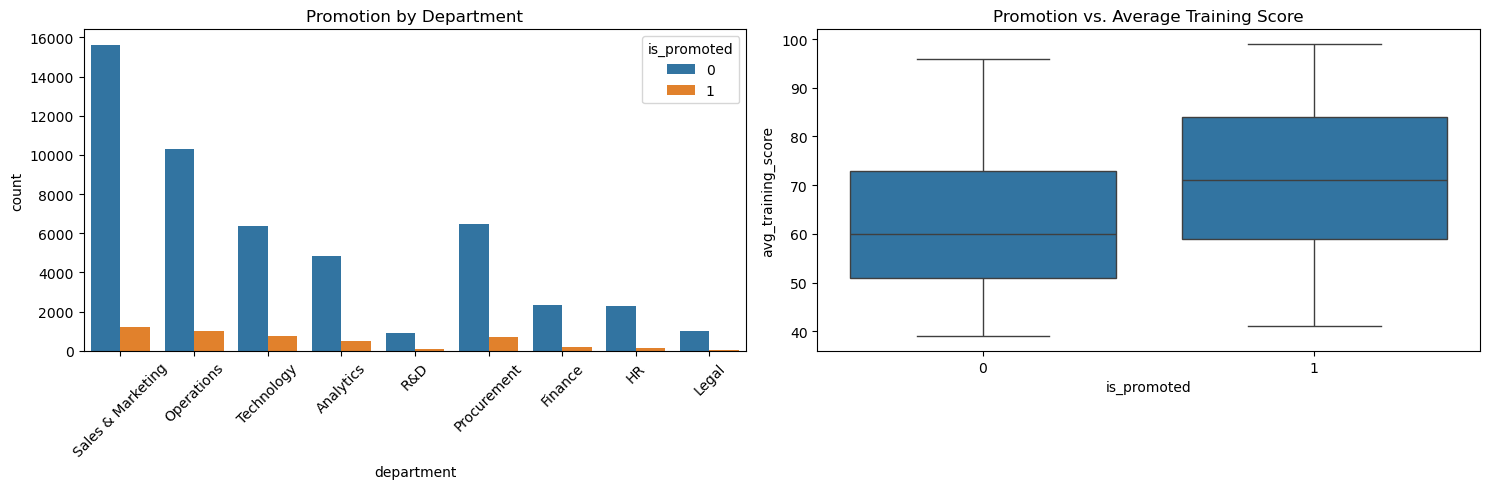

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x='department', hue='is_promoted', data=train_df, ax=axes[0])
axes[0].set_title('Promotion by Department')
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(x='is_promoted', y='avg_training_score', data=train_df, ax=axes[1])
axes[1].set_title('Promotion vs. Average Training Score')
plt.tight_layout()
plt.show()

In [7]:
target = 'is_promoted'
features = [col for col in train_df.columns if col not in ['employee_id', target]]

In [8]:
numerical_features = train_df[features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = train_df[features].select_dtypes(include='object').columns.tolist()


In [9]:
#2. Pre-processing

In [10]:

def preprocess_data(df):
    # Define categorical columns
    categorical_cols = ['department', 'region', 'education', 'gender', 'recruitment_channel']
    
    # Apply label encoding to categorical columns
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
    
    # Define numerical columns
    numerical_cols = ['no_of_trainings', 'age', 'length_of_service', 'avg_training_score']
    
    # Apply standard scaling to numerical columns
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    
    return df

In [11]:
train_df_processed = preprocess_data(train_df.copy())
test_df_processed = preprocess_data(test_df.copy())

In [12]:
X_train = train_df_processed.drop(['employee_id', 'is_promoted'], axis=1)
y_train = train_df_processed['is_promoted']
X_test = test_df_processed.drop('employee_id', axis=1)

In [13]:
#  Modeling and Fine Tuning

In [14]:
#Decision Tree

In [15]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_params = {
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [1, 5, 10]
}


In [16]:
dt_grid = GridSearchCV(dt_model, dt_params, cv=5, scoring='accuracy', n_jobs=-1)
dt_grid.fit(X_train, y_train)
best_dt_model = dt_grid.best_estimator_
print(f"Best Decision Tree Parameters: {dt_grid.best_params_}")

Best Decision Tree Parameters: {'max_depth': 15, 'min_samples_leaf': 10}


In [17]:
#Random Forest Classifier

In [36]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(random_state=42))])


model.fit(X_train, y_train)
y_train_pred = model.predict(X_train) 
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(classification_report(y_train, y_train_pred))

Accuracy: 0.9997
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50140
           1       1.00      1.00      1.00      4668

    accuracy                           1.00     54808
   macro avg       1.00      1.00      1.00     54808
weighted avg       1.00      1.00      1.00     54808



In [37]:
y_train_pred = model.predict(X_train)
print("\n--- Model Evaluation on Training Data ---")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(classification_report(y_train, y_train_pred))




--- Model Evaluation on Training Data ---
Accuracy: 0.9997
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50140
           1       1.00      1.00      1.00      4668

    accuracy                           1.00     54808
   macro avg       1.00      1.00      1.00     54808
weighted avg       1.00      1.00      1.00     54808



In [39]:

print("\n--- Fine-tuning (GridSearchCV Example) ---")
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None]
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)



--- Fine-tuning (GridSearchCV Example) ---
Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['department',
                                                                          'region',
                                                                          'education',
                                                                          'gender',
                                                                          'recruitment_channel']),
                                                                        ('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['no_of_trainings',
                                                                          'age',
                                                                          'previous_year_rating',
                                                                          'length_of_service',
                                                                          'KPIs_met '
                                                                          '>80%',
                                                                          'awards_won?',
                                                                          'avg_training_score'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [10, 20, None],
                         'classifier__n_estimators': [100, 200]},
             scoring='accuracy', verbose=1)

In [41]:
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# --- Make predictions with the best model ---
test_predictions = best_model.predict(X_test)

Best parameters: {'classifier__max_depth': None, 'classifier__n_estimators': 200}
Best cross-validation accuracy: 0.9337


In [42]:
submission_df = sample_submission_df.copy()
submission_df[target] = test_predictions

In [43]:
submission_df.to_csv('submission.csv', index=False)
print("\nSubmission file 'submission.csv' created successfully.")
print(submission_df.head())


Submission file 'submission.csv' created successfully.
   employee_id  is_promoted
0         8724            0
1        74430            0
2        72255            0
3        38562            0
4        64486            0


In [ ]:
#SVM


In [ ]:
#svm_grid = GridSearchCV(svm_model, svm_params, cv=5, scoring='accuracy', n_jobs=-1)
#svm_grid.fit(X_train, y_train)
#best_svm_model = svm_grid.best_estimator_
#print(f"Best SVM Parameters: {svm_grid.best_params_}")

In [23]:



svm_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), 
    ('svm', SVC(random_state=42))
])


svm_params = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': [0.001, 0.01, 0.1, 1],
}


svm_pipeline.fit(X_train, y_train)


y_train_pred = svm_pipeline.predict(X_train)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(classification_report(y_train, y_train_pred))

Accuracy: 0.9148
              precision    recall  f1-score   support

           0       0.91      1.00      0.96     50140
           1       0.00      0.00      0.00      4668

    accuracy                           0.91     54808
   macro avg       0.46      0.50      0.48     54808
weighted avg       0.84      0.91      0.87     54808



C:\Users\chait\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chait\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chait\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
